# Yield Curve Fitting with Nelson-Siegel and Svensson Models

This notebook demonstrates fitting parametric yield curve models to bond data.

**Author:** Brett Cooper  
**Date:** 2025-01-15  
**Purpose:** Fit yield curves for multiple countries and create weighted composite curves

## Models Used
- **Nelson-Siegel:** 4-parameter model for smooth yield curves
- **Svensson:** 6-parameter extension for more complex shapes

In [1]:
# Import required libraries
import sys
sys.path.insert(0, '../src')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

# Import our custom modules
from yield_curves.yield_curve_fitting import (
    fit_nelson_siegel,
    fit_svensson,
    create_weighted_curve
)

# Set plotting style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (14, 8)

print("Libraries loaded successfully!")

Libraries loaded successfully!


## 1. Load Bond Data

Load the raw bond yield data for multiple countries and maturities.

In [2]:
# Define data paths
DATA_DIR = Path('../data/raw')

# Load bond data
bond_data = pd.read_csv(DATA_DIR / 'bond_dat.csv', header=None)

print(f"Bond data shape: {bond_data.shape}")
print("\nFirst few rows:")
bond_data.head(10)

Bond data shape: (248, 147)

First few rows:


,0,1,2,3,4,5,6,7,8,9,...,137,138,139,140,141,142,143,144,145,146
0,Years to maturity,1,2,3,4,5,7,9,10,15,...,0.3333333333,0.5,1,2,3,5,7,10,20,30
1,Date code,1Y,2Y,3Y,4Y,5Y,7Y,9Y,10Y,15Y,...,4M,6M,1Y,2Y,3Y,5Y,7Y,10Y,20Y,30Y
2,Country Code,AU,AU,AU,AU,AU,AU,AU,AU,AU,...,US,US,US,US,US,US,US,US,US,US
3,NaN,U1Y-FDS,U2Y-FDS,U3Y-FDS,U4Y-FDS,U5Y-FDS,U7Y-FDS,U9Y-FDS,10Y-FDS,15Y-FDS,...,S4M-FDS,S6M-FDS,S1Y-FDS,S2Y-FDS,S3Y-FDS,S5Y-FDS,S7Y-FDS,10Y-FDS,20Y-FDS,30Y-FDS
4,FDS code,TRYAU1Y-FDS,TRYAU2Y-FDS,TRYAU3Y-FDS,TRYAU4Y-FDS,TRYAU5Y-FDS,TRYAU7Y-FDS,TRYAU9Y-FDS,TRYAU10Y-FDS,TRYAU15Y-FDS,...,TRYUS4M-FDS,TRYUS6M-FDS,TRYUS1Y-FDS,TRYUS2Y-FDS,TRYUS3Y-FDS,TRYUS5Y-FDS,TRYUS7Y-FDS,TRYUS10Y-FDS,TRYUS20Y-FDS,TRYUS30Y-FDS
5,Name,Australia Benchmark Bond - 1 Year,Australia Benchmark Bond - 2 Year,Australia Benchmark Bond - 3 Year,Australia Benchmark Bond - 4 Year,Australia Benchmark Bond - 5 Year,Australia Benchmark Bond - 7 Year,Australia Benchmark Bond - 9 Year,Australia Benchmark Bond - 10 Year,Australia Benchmark Bond - 15 Year,...,US Benchmark Bond - 4 Month,US Benchmark Bill - 6 Month,US Benchmark Bond - 1 Year,US Benchmark Bond - 2 Year,US Benchmark Bond - 3 Year,US Benchmark Bond - 5 Year,US Benchmark Bond - 7 Year,US Benchmark Bond - 10 Year,US Benchmark Bond - 20 Year,US Benchmark Bond - 30 Year
6,Type,Yield,Yield,Yield,Yield,Yield,Yield,Yield,Yield,Yield,...,Yield,Yield,Yield,Yield,Yield,Yield,Yield,Yield,Yield,Yield
7,2005-04-29,NaN,5.235,5.29,NaN,5.32,NaN,NaN,5.35,NaN,...,NaN,3.08,3.33,3.653,3.73,3.9,4.03,4.21,NaN,4.53
8,2005-05-31,NaN,5.18,5.14,NaN,5.135,NaN,NaN,5.15,NaN,...,NaN,3.09,3.32,3.597,3.65,3.76,3.86,4,NaN,4.36
9,2005-06-30,NaN,5.145,5.1,NaN,5.1,NaN,NaN,5.105,NaN,...,NaN,3.24,3.45,3.657,3.67,3.72,3.8,3.94,NaN,4.19


## 2. Parse and Structure Bond Data

Extract metadata (countries, maturities) and organize the yield data.

In [3]:
# Extract metadata from specific rows (matching R code structure)
# Row 1: Maturities
# Row 3: Countries
# Row 8+: Dates and yields

maturities = pd.to_numeric(bond_data.iloc[0, 1:], errors='coerce').values
countries = bond_data.iloc[2, 1:].values
dates = pd.to_datetime(bond_data.iloc[7:, 0])

# Extract yield matrix (rows 8+, columns 2+)
yields_matrix = bond_data.iloc[7:, 1:].apply(pd.to_numeric, errors='coerce').values

print(f"Number of dates: {len(dates)}")
print(f"Number of series: {len(countries)}")
print(f"Unique countries: {sorted(set(countries))}")
print(f"Maturities range: {np.nanmin(maturities):.1f} to {np.nanmax(maturities):.1f} years")

Number of dates: 241
Number of series: 146
Unique countries: ['AU', 'BR', 'CA', 'CH', 'CN', 'EU', 'GB', 'IN', 'JP', 'MX', 'US']
Maturities range: 0.1 to 50.0 years


## 3. Fit Yield Curves for a Single Country

Demonstrate fitting process for one country on a specific date.

In [4]:
# Select a country and date for demonstration
demo_country = 'US'
demo_date_idx = -1  # Most recent date

# Filter data for this country
country_mask = countries == demo_country
demo_maturities = maturities[country_mask]
demo_yields = yields_matrix[demo_date_idx, country_mask] / 100  # Convert to decimal

# Remove any NaN values
valid_idx = ~np.isnan(demo_yields)
demo_maturities = demo_maturities[valid_idx]
demo_yields = demo_yields[valid_idx]

print(f"Country: {demo_country}")
print(f"Date: {dates.iloc[demo_date_idx]}")
print(f"Number of points: {len(demo_yields)}")
print(f"\nYields by maturity:")
for mat, yld in zip(demo_maturities, demo_yields):
    print(f"  {mat:5.1f}Y: {yld*100:6.3f}%")

Country: US
Date: 2025-04-30 00:00:00
Number of points: 13

Yields by maturity:
    0.1Y:  4.292%
    0.2Y:  4.360%
    0.2Y:  4.288%
    0.3Y:  4.370%
    0.5Y:  4.171%
    1.0Y:  3.849%
    2.0Y:  3.595%
    3.0Y:  3.582%
    5.0Y:  3.717%
    7.0Y:  3.927%
   10.0Y:  4.155%
   20.0Y:  4.696%
   30.0Y:  4.692%


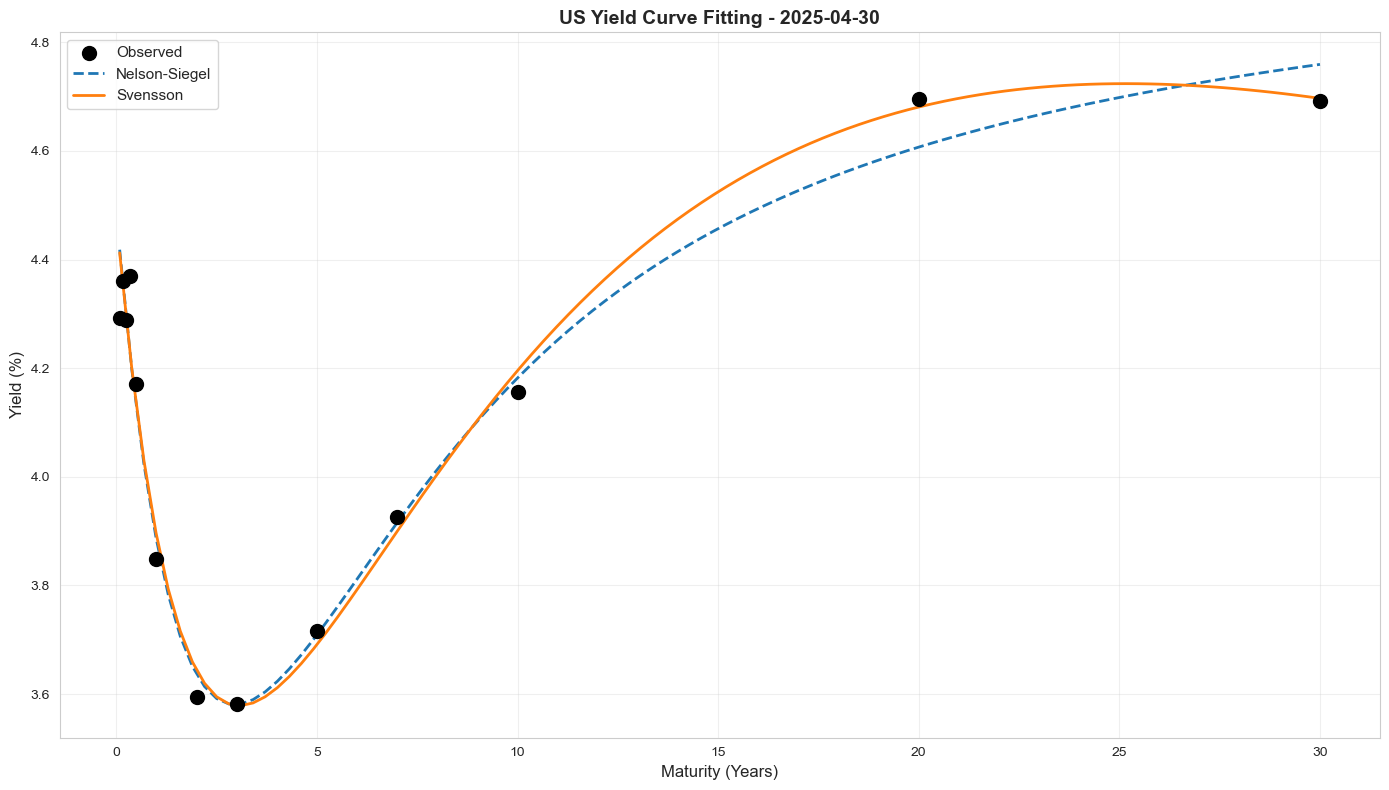


Nelson-Siegel Parameters:
  β₀ (level): 0.0506
  β₁ (slope): -0.0058
  β₂ (curvature): -0.0402
  τ (decay): 1.9902


In [5]:
# Fit both models
ns_curve, ns_fitted = fit_nelson_siegel(demo_yields, demo_maturities)
sv_curve, sv_fitted = fit_svensson(demo_yields, demo_maturities)

# Generate smooth curve for plotting
smooth_maturities = np.linspace(demo_maturities.min(), demo_maturities.max(), 100)
ns_smooth = np.array([ns_curve(t) for t in smooth_maturities])
sv_smooth = np.array([sv_curve(t) for t in smooth_maturities])

# Plot results
fig, ax = plt.subplots(figsize=(14, 8))

ax.scatter(demo_maturities, demo_yields * 100, s=100, color='black', 
           label='Observed', zorder=5)
ax.plot(smooth_maturities, ns_smooth * 100, linewidth=2, 
        label='Nelson-Siegel', linestyle='--')
ax.plot(smooth_maturities, sv_smooth * 100, linewidth=2, 
        label='Svensson', linestyle='-')

ax.set_xlabel('Maturity (Years)', fontsize=12)
ax.set_ylabel('Yield (%)', fontsize=12)
ax.set_title(f'{demo_country} Yield Curve Fitting - {dates.iloc[demo_date_idx].strftime("%Y-%m-%d")}',
             fontsize=14, fontweight='bold')
ax.legend(fontsize=11)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\nNelson-Siegel Parameters:")
print(f"  β₀ (level): {ns_curve.beta0:.4f}")
print(f"  β₁ (slope): {ns_curve.beta1:.4f}")
print(f"  β₂ (curvature): {ns_curve.beta2:.4f}")
print(f"  τ (decay): {ns_curve.tau:.4f}")

## 4. Fit Curves for All Countries Over Time

Process all countries and dates to build a complete yield curve database.

In [6]:
# Define fitting period (from 2020 onwards as in R code)
START_YEAR = 2020
fitting_dates = dates[dates >= f'{START_YEAR}-01-01']

# Get unique maturities for output
unique_maturities = sorted(set(maturities[~np.isnan(maturities)]))
unique_countries = sorted(set(countries))

print(f"Fitting period: {fitting_dates.min()} to {fitting_dates.max()}")
print(f"Number of dates: {len(fitting_dates)}")
print(f"Countries: {unique_countries}")
print(f"Output maturities: {unique_maturities}")
print(f"\nThis will create {len(unique_countries)} x {len(fitting_dates)} x {len(unique_maturities)} fitted yields")

Fitting period: 2020-01-31 00:00:00 to 2025-04-30 00:00:00
Number of dates: 64
Countries: ['AU', 'BR', 'CA', 'CH', 'CN', 'EU', 'GB', 'IN', 'JP', 'MX', 'US']
Output maturities: [np.float64(0.08333333333), np.float64(0.1666666667), np.float64(0.25), np.float64(0.3333333333), np.float64(0.5), np.float64(1.0), np.float64(2.0), np.float64(3.0), np.float64(4.0), np.float64(5.0), np.float64(6.0), np.float64(7.0), np.float64(8.0), np.float64(9.0), np.float64(10.0), np.float64(11.0), np.float64(12.0), np.float64(15.0), np.float64(20.0), np.float64(25.0), np.float64(30.0), np.float64(40.0), np.float64(50.0)]

This will create 11 x 64 x 23 fitted yields


In [7]:
# Initialize storage for fitted yields
# Structure: [country, date, maturity]
ns_fitted_yields = np.zeros((len(unique_countries), len(fitting_dates), len(unique_maturities)))
sv_fitted_yields = np.zeros((len(unique_countries), len(fitting_dates), len(unique_maturities)))

# Fit curves (this may take a minute)
print("Fitting yield curves...")
errors = []

for date_idx, date in enumerate(fitting_dates):
    # Get the row index in original data
    row_idx = dates[dates == date].index[0] - dates.index[0]
    
    for country_idx, country in enumerate(unique_countries):
        try:
            # Get data for this country and date
            country_mask = countries == country
            obs_maturities = maturities[country_mask]
            obs_yields = yields_matrix[row_idx, country_mask] / 100
            
            # Remove NaN values
            valid = ~np.isnan(obs_yields)
            if valid.sum() < 3:  # Need at least 3 points
                continue
                
            clean_mats = obs_maturities[valid]
            clean_yields = obs_yields[valid]
            
            # Fit curves
            ns_curve, _ = fit_nelson_siegel(clean_yields, clean_mats)
            sv_curve, _ = fit_svensson(clean_yields, clean_mats)
            
            # Get fitted values at standard maturities
            for mat_idx, maturity in enumerate(unique_maturities):
                ns_fitted_yields[country_idx, date_idx, mat_idx] = ns_curve(maturity) * 100
                sv_fitted_yields[country_idx, date_idx, mat_idx] = sv_curve(maturity) * 100
                
        except Exception as e:
            errors.append((date, country, str(e)))
    
    if (date_idx + 1) % 50 == 0:
        print(f"  Processed {date_idx + 1}/{len(fitting_dates)} dates")

print(f"\nFitting complete!")
print(f"Errors encountered: {len(errors)}")

Fitting yield curves...
  Processed 50/64 dates

Fitting complete!
Errors encountered: 0


## 5. Create Weighted Composite Curve (WPU)

Combine individual country curves using economic weights.

In [8]:
# Load WPU weights
wpu_weights = pd.read_excel(DATA_DIR / 'wpu_weights.xlsx')

print("WPU Weights structure:")
print(wpu_weights.head())
print(f"\nShape: {wpu_weights.shape}")
print(f"Columns: {wpu_weights.columns.tolist()}")

WPU Weights structure:
     Column1     AUD     BRL     CAD      CHF     CNY      EUR      GBP  \
0 1989-11-30  3.1920  1.3518  1.5478  16.0764  0.0000  16.0764  16.0764   
1 1990-11-30  2.4867  1.6439  1.2434  12.4335  0.0000  17.3283  17.3283   
2 1991-11-29  2.4194  1.6322  1.2096  12.0963  0.0000  17.9886  17.9886   
3 1992-11-30  2.1349  1.3806  3.2024   9.6070  0.0000  20.3638  14.9438   
4 1993-11-30  1.9827  1.2452  2.9742   8.9225  1.3475  20.2945  13.8793   

      INR      JPY  MXN     RUB      USD  
0  1.1994  16.0764  0.0  0.0000  28.4033  
1  1.1315  17.3283  0.0  0.0000  29.0762  
2  1.1217  17.9886  0.0  0.0000  27.5549  
3  0.9067  20.3638  0.0  0.0000  27.0969  
4  0.7828  20.2945  0.0  1.4672  26.8095  

Shape: (1650, 13)
Columns: ['Column1', 'AUD', 'BRL', 'CAD', 'CHF', 'CNY', 'EUR', 'GBP', 'INR', 'JPY', 'MXN', 'RUB', 'USD']


# Calculate WPU weighted curve from individual country curves
print("Calculating WPU weighted yield curve...")

# Map country codes to weight column names
country_map = {
    'AU': 'AUD', 'BR': 'BRL', 'CA': 'CAD', 'CH': 'CHF', 
    'CN': 'CNY', 'EU': 'EUR', 'GB': 'GBP', 'IN': 'INR',
    'JP': 'JPY', 'MX': 'MXN', 'US': 'USD'
}

# Prepare weights dataframe
wpu_weights['Date'] = pd.to_datetime(wpu_weights['Column1'])
wpu_weights = wpu_weights.set_index('Date')

# Initialize WPU yield array (same structure as country arrays)
wpu_fitted_yields = np.zeros((len(fitting_dates), len(unique_maturities)))

# Calculate weighted average for each date
for date_idx, date in enumerate(fitting_dates):
    # Get weights for this date (or closest previous date)
    weight_date = wpu_weights.index[wpu_weights.index <= date]
    if len(weight_date) == 0:
        print(f"Warning: No weights available for {date}, skipping")
        continue
    
    weight_date = weight_date[-1]
    weights_row = wpu_weights.loc[weight_date]
    
    # Calculate weighted average across countries
    for mat_idx in range(len(unique_maturities)):
        weighted_sum = 0
        total_weight = 0
        
        for country_idx, country in enumerate(unique_countries):
            if country in country_map:
                weight_col = country_map[country]
                weight = weights_row[weight_col]
                
                # Get yield for this country/date/maturity
                country_yield = ns_fitted_yields[country_idx, date_idx, mat_idx]
                
                if not np.isnan(country_yield) and weight > 0:
                    weighted_sum += country_yield * weight
                    total_weight += weight
        
        # Store weighted average
        if total_weight > 0:
            wpu_fitted_yields[date_idx, mat_idx] = weighted_sum / total_weight

print(f"WPU curve calculated for {len(fitting_dates)} dates")
print(f"Sample WPU yields for {fitting_dates.iloc[0]}: {wpu_fitted_yields[0, :5]}")

In [ ]:
# Create output directory
PROCESSED_DIR = Path('../data/processed')
PROCESSED_DIR.mkdir(exist_ok=True, parents=True)

# Combine country yields with WPU
# Add WPU as an additional "country" in the array
all_countries = unique_countries + ['WPU']
all_ns_yields = np.concatenate([
    ns_fitted_yields,
    wpu_fitted_yields.reshape(1, len(fitting_dates), len(unique_maturities))
], axis=0)

# Save as NumPy arrays (Python equivalent of .Rdata)
np.savez(
    PROCESSED_DIR / 'fitted_yield_curves.npz',
    ns_yields=all_ns_yields,
    sv_yields=sv_fitted_yields,
    countries=all_countries,
    dates=fitting_dates.values,
    maturities=unique_maturities
)

print(f"Fitted yields saved to {PROCESSED_DIR / 'fitted_yield_curves.npz'}")
print(f"Included {len(all_countries)} countries: {all_countries}")
print("\nUse these in the bond swap analysis notebook!")

## Summary

This notebook has:
1. Loaded and structured multi-country bond yield data
2. Demonstrated Nelson-Siegel and Svensson curve fitting
3. Fitted curves for all countries over time
4. Saved processed yields for downstream analysis

## Next Steps

- Return to `01_bond_swap_analysis.ipynb` to use these fitted curves
- Explore yield curve evolution over time
- Analyze interest rate differentials across countries